In [2]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
!pip install split-folders
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 31.3 MB/s eta 0:00:00


In [4]:
import splitfolders 
import visualkeras
splitfolders.ratio("/kaggle/input/agronify-dataset/DiseasedPlants/DiseasedPlants/Pertanian/Padi", 
                   output="padi-data", 
                   seed=42, 
                   ratio=(.8, .1, .1), 
                   group_prefix=None) 

Copying files: 4687 files [00:48, 96.31 files/s] 


In [12]:
training_dir = os.path.join('padi-data', 'train')
testing_dir = os.path.join('padi-data', 'test')
validating_dir = os.path.join('padi-data', 'val')

In [13]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 3748 images belonging to 5 classes.
Found 467 images belonging to 5 classes.
Found 472 images belonging to 5 classes.


In [14]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Rice__brown_spot': 0, 'Rice__healthy': 1, 'Rice__hispa': 2, 'Rice__leaf_blast': 3, 'Rice__neck_blast': 4}
['Rice__brown_spot', 'Rice__healthy', 'Rice__hispa', 'Rice__leaf_blast', 'Rice__neck_blast']


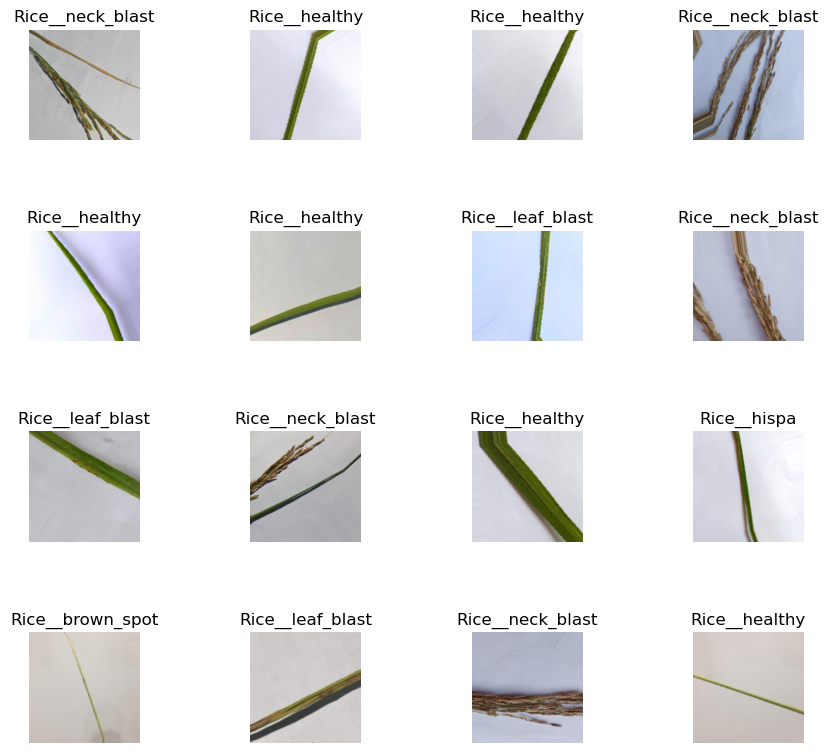

In [15]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

In [16]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, total_epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.total_epochs = total_epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.total_epochs:
            print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
            self.ask = False
        if self.total_epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Loading model with weights from epoch', self.best_epoch)
        self.model.set_weights(self.best_weights)
        training_duration = time.time() - self.start_time
        hours = training_duration // 3600
        minutes = (training_duration - (hours * 3600)) // 60
        seconds = training_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
        else:
            print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nDo you want to continue training (Y/N)?')
                ans = input()

                if ans.lower() == 'n':
                    print('Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += 1

In [35]:
tf.keras.backend.clear_session()

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

image_shape = (224, 224, 3)
model_name = 'MobileNet'
base_model = MobileNet(
    include_top=False,
    input_shape=image_shape,
    pooling=None,  # Remove the pooling parameter
    weights='imagenet',

)
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)

output = Dense(class_count, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)
# model.summary()

model.compile(
    Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_epochs = 100
ask_epoch = 25
ask_callback = LR_ASK(model, total_epochs, ask_epoch)
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=1)
callbacks = [rlronp_callback, ask_callback, earlystop_callback]

Number of layers in the base model:  86


In [36]:
training_history = model.fit(train_generator,
                             epochs=total_epochs,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             initial_epoch=0)

Training will proceed until epoch 25 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/100
118/118 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.7468
Validation loss of  3.5907 is below the lowest loss, saving weights from epoch 1   as the best weights
118/118 [==============================] - 142s 1s/step - loss: 0.7137 - accuracy: 0.7468 - val_loss: 3.5907 - val_accuracy: 0.5054 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.8108
Validation loss of  1.0054 is below the lowest loss, saving weights from epoch 2   as the best weights
118/118 [==============================] - 135s 1s/step - loss: 0.4785 - accuracy: 0.8108 - val_loss: 1.0054 - val_accuracy: 0.6895 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8370
Validation loss of  0.7251 is below the lowest loss, 

 n


Training halted on epoch 25 due to user input

118/118 [==============================] - 275s 2s/step - loss: 0.2398 - accuracy: 0.9122 - val_loss: 0.3451 - val_accuracy: 0.8865 - lr: 1.0000e-06
Loading model with weights from epoch 20
Training elapsed time was 1.0 hours,  3.0 minutes, 2.14 seconds)


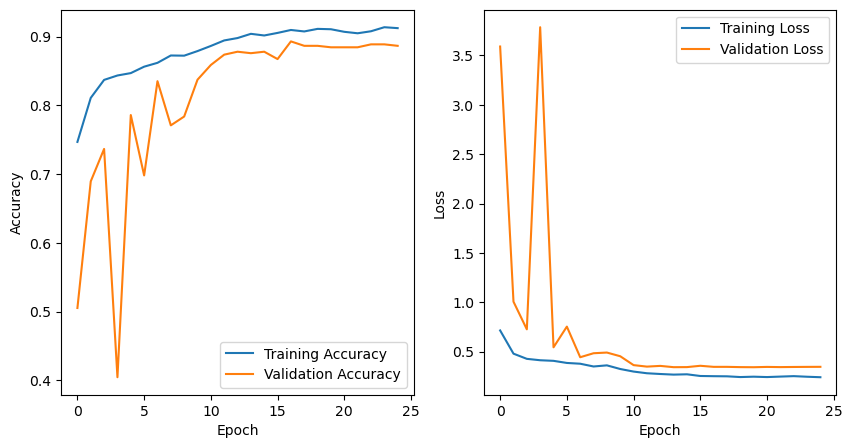

In [37]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [38]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

15/15 [==============================] - 13s 870ms/step - loss: 0.3598 - accuracy: 0.8856
Test loss: 0.35982954502105713 / Test accuracy: 0.8855932354927063


In [39]:
model.save('padi-final.h5')